<a href="https://colab.research.google.com/github/jyj1206/SoloDeepLearning/blob/main/Chapter4_Well_Organized_DL_Code_from_Scartch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Training with Fully Connected (FC) Laye

In [142]:
# 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms

In [143]:
# CIFAR10 데이터 다운로드 및 불러오기
transform = transforms.Compose(
    {transforms.ToTensor(), # 이미지를 Tensor로 변경, 0~1로 스케일됨
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))} # normlize를 RGB 채널별로, 0.5로 shift 시킴 (-0.5 ~ 0.5), 0.5로 나누어줌 (-1 ~ 1) - normalize를 각 채널별로 적용
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                          shuffle = True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size = batch_size,
                                         shuffle = False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'dear', 'dog', 'forg', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


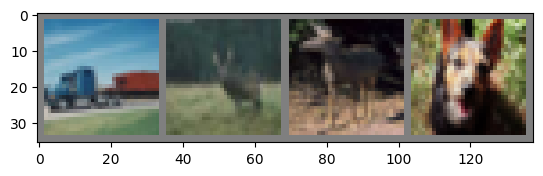

truck  dear  dear   dog


In [104]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg =img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4))) # ground truth 출력

In [105]:
# Inspect 데이터셋 - 데이터마다 shape이 다를 수 있으모로
print(type(images)) # 데이터 타입
print(images.shape) # 데이터 shape (배치가 4개, RGB, 가로, 세로)

print(type(labels)) # 레이블 타입
print(labels.shape) # 레이블 shape
print(labels) # 값 출력 (이미지에 매칭되는 인덱스를 의미)

<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'>
torch.Size([4])
tensor([9, 4, 4, 5])


In [106]:
# 모델 생성
import torch.nn as nn

class MLP(nn.Module) :
  def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim = hid_dim
    self.n_layer = n_layer
    self.act = act

    self.fc_in = nn.Linear(self.in_dim, self.hid_dim)

    self.linears = nn.ModuleList(nn.Linear(self.hid_dim, self.hid_dim) for _  in range(self.n_layer-1) )

    self.fc_out = nn.Linear(self.hid_dim, self.out_dim)

    if self.act == 'relu':
      self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.fc_in(x))
    for fc in self.linears:
      x = self.act(fc(x))
    x = self.fc_out(x)
    return x

In [107]:
model = MLP(3072, 10, 100, 4, 'relu')

In [108]:
print(model)

MLP(
  (fc_in): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc_out): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


## Loss/Optimization

In [109]:
# Loss function, Optimization 정의
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


## Train Process

In [110]:
# 모델 학습
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader):
    inputs, labels = data

    # reshape 여기서 -1은 남아있는 몫을 채워줌
    inputs = inputs.view(-1, 3072)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.175
[1,  4000] loss: 1.895
[1,  6000] loss: 1.756
[1,  8000] loss: 1.705
[1, 10000] loss: 1.652
[2,  2000] loss: 1.583
[2,  4000] loss: 1.574
[2,  6000] loss: 1.553
[2,  8000] loss: 1.535
[2, 10000] loss: 1.497
Finished Training


## Validation, Test Prcoess

In [116]:
# Val Accuracy / Val Loss 측정
correct = 0
total = 0
val_loss = 0
with torch.no_grad():
  for data in valloader:
    images, labels = data
    images = images.view(-1, 3072)
    outputs = model(images)

    loss = criterion(outputs, labels)
    val_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  val_loss = val_loss / len(valloader)
  acc = 100 * correct / total

print(f'Accuracy of the network on the 10000 val images: {acc:.2f}% {val_loss:.2f}')

Accuracy of the network on the 10000 val images: 44.73% 1.53


In [117]:
# Test Accuracy 측정
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.view(-1, 3072)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total

print(f'Accuracy of the network on the 10000 test images: {acc}%')

Accuracy of the network on the 10000 test images: 45.86%


## Experiments

In [168]:
def experiment(args):
  model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
  model.cuda()

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = args.lr, momentum = args.mm)

  ## ==== Train ==== ##
  for epoch in range(args.epoch):

    model.train()  # 학습 모드 설정

    running_loss = 0.0
    train_loss = 0.0
    for i, data in enumerate(trainloader):
      inputs, labels = data
      # reshape, 여기서 -1은 남아있는 몫을 채워줌
      inputs = inputs.view(-1, 3072)

      inputs = inputs.cuda()
      labels = labels.cuda()

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      train_loss += loss.item()
      if i % 2000 == 1999: # print every 2000 mmini-batches
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

    # 에포크 종료 후 미니배치 개수로 나누기
    train_loss = train_loss / len(trainloader)

    ## ==== validation ==== ##
    model.eval()  # 평가 모드 설정

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
      for data in valloader:
        images, labels = data
        images = images.view(-1, 3072)

        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(valloader)
      acc = 100 * correct / total

    print(f'Epoch {epoch}, Train Loss : {train_loss:.2f}, Val Loss : {val_loss:.2f}, Val Acc : {acc}')


  ## ==== Evaluation ==== ##
  model.eval()  # 테스트 평가 모드 설정

  correct = 0
  total = 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.view(-1, 3072)

      images = images.cuda()
      labels = labels.cuda()

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total

  print(f'Accuracy of the network on the 10000 test images: {test_acc}%')

  return train_loss, val_loss, train_loss, test_acc


In [169]:
import argparse

# seed 설정
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 2

In [170]:
experiment(args)

[1,  2000] loss: 2.297
[1,  4000] loss: 2.106
[1,  6000] loss: 1.934
[1,  8000] loss: 1.803
[1, 10000] loss: 1.732
Epoch 0, Train Loss : 1.97, Val Loss : 1.72, Val Acc : 37.86
[2,  2000] loss: 1.650
[2,  4000] loss: 1.628
[2,  6000] loss: 1.608
[2,  8000] loss: 1.587
[2, 10000] loss: 1.559
Epoch 1, Train Loss : 1.61, Val Loss : 1.57, Val Acc : 43.68
Accuracy of the network on the 10000 test images: 44.77%


(1.6063425967127085, 1.5722606544733047, 1.6063425967127085, 44.77)

In [171]:
list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

[1,  2000] loss: 2.219
[1,  4000] loss: 1.930
[1,  6000] loss: 1.799
[1,  8000] loss: 1.744
[1, 10000] loss: 1.679
Epoch 0, Train Loss : 1.87, Val Loss : 1.69, Val Acc : 39.04
[2,  2000] loss: 1.646
[2,  4000] loss: 1.615
[2,  6000] loss: 1.580
[2,  8000] loss: 1.591
[2, 10000] loss: 1.564
Epoch 1, Train Loss : 1.60, Val Loss : 1.59, Val Acc : 43.46
Accuracy of the network on the 10000 test images: 44.41%
(1.5990124841988087, 1.5872162140488624, 1.5990124841988087, 44.41)
[1,  2000] loss: 2.232
[1,  4000] loss: 1.913
[1,  6000] loss: 1.774
[1,  8000] loss: 1.709
[1, 10000] loss: 1.652
Epoch 0, Train Loss : 1.86, Val Loss : 1.67, Val Acc : 39.89
[2,  2000] loss: 1.580
[2,  4000] loss: 1.569
[2,  6000] loss: 1.554
[2,  8000] loss: 1.533
[2, 10000] loss: 1.530
Epoch 1, Train Loss : 1.55, Val Loss : 1.55, Val Acc : 44.74
Accuracy of the network on the 10000 test images: 45.82%
(1.553063637138903, 1.5483416438162327, 1.553063637138903, 45.82)
[1,  2000] loss: 2.179
[1,  4000] loss: 1.898
[1